# Advanced numerical methods Training Course
## Hands-on session: The spherical harmonics dwarf
Andreas Mueller, ECMWF (andreas.mueller@ecmwf.int)
___
Many global atmospheric models are based on the spectral transform method with spherical harmonics. Transforming the fields from physical space to spectral space converts spatial derivatives into algebraic expressions. This makes the spectral transform method a very efficient approach for solving differential equations. One of the atmospheric models based on the spectral transform method with spherical harmonics is the Integrated Forecasting System (IFS). IFS is used very successfully by the European Centre for Medium-range Weather Forecasts (ECMWF) for operational weather prediction. We will look in this exercise at the spherical harmonics dwarf which is the code that performs the spectral transform in IFS.

The focus of this exercise will be on writing a simple spectral transform code to get a better understanding of the spectral transform method. This will allow the students to understand the basic functionality of the dwarf. The code written by the students will also serve as an example for improving the performance of scientific code in general. We will consider different strategies to analyse and optimise the efficiency of code. This makes this exercise not only well suited for students who are interested in understanding the fundamental idea behind the spectral transform method but also for students who want to learn how to improve the computational performance of their own code.

The code of IFS is written in Fortran. To make it easier to experiment with different implementations and to easily plot the results we use Python in this (Jupyter) Notebook.

If you want to use this notebook on your own laptop you can also find it here: https://notebooks.azure.com/anmrde/libraries/tcnm2019
On that website you can even run it on Microsoft's cloud servers by clicking on "clone".

## Motivation
Creating interactive plots in Python in which you can rotate the earth and look at fields plotted on the globe from all directions does not result in satisfying performance. For this reason most of the globe visualisations can be found in a little web-app created with Javascript. You can find it here: http://anmrde.github.io/spectral

**Task:** Visit this web-app and do the quizzes in there! This web-app teaches you all of the main ideas behind the spectral transform method and is a great preparation for this Jupyter notebook.

### 1.1 Introduction
#### 1.1.1 Installation of required libraries
We first need to download some spectral data. Don't worry! You don't need to change anything. Just click on the cell (gray box) below and press `Shift-Enter` or press the <button class='btn btn-default btn-xs'><i class="icon-step-forward fa fa-step-forward"></i></button> button in the toolbar above. This runs the cell and selects the next cell.  You see a filled black circle next to "Python 3" in the top right corner while Python is running. Once Python has finished the circle becomes light gray inside.

In [6]:
# download spectral sample data:
!curl -O https://raw.githubusercontent.com/anmrde/spectral/master/T159_geo.npz
!curl -O https://raw.githubusercontent.com/anmrde/spectral/master/T1279_geo.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  194k  100  194k    0     0   708k      0 --:--:-- --:--:-- --:--:--  711k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.0M  100 12.0M    0     0  6190k      0  0:00:01  0:00:01 --:--:-- 6187k


#### 1.1.2 Definition of some useful helper functions

The next cell defines a function to plot the results with matplotlib. It requires the data to be available on a regular lat-lon mesh (see the definition of the function `plotSpectralData` below for an example of how to create a data array in lat-lon coordinates). The arguments of the function `plotGlobe` are:
- lons: numpy array with the longitude values of the mesh
- lats: numpy array with the latitude values of the mesh
- data: grid-point data for each point of the mesh

**Task:** Run the next three cells.

In [1]:
def truncateData(N,M,rawData):
    truncatedData = np.zeros((N+1)*(N+2))
    k = 0; j=0
    for m in range(0,M+1):
        for n in range(m,M+1):
            if n<=N and m<=N:
                truncatedData[j] = rawData[k]
                truncatedData[j+1] = rawData[k+1]
                j = j+2
            k = k+2
    return truncatedData

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from matplotlib import cm
cdict = {'red':   [[0.0,  51./255., 51./255.],
                   [0.01, 34./255., 34./255.],
                   [0.2,  1.0, 1.0],
                   [0.4,  128./255., 128./255.],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  51./255., 51./255.],
                   [0.01, 139./255., 139./255.],
                   [0.2,  1.0, 1.0],
                   [0.4,  92./255., 92./255.],
                   [1.0,  1.0, 1.0]],
         'blue':  [[0.0,  153./255., 153./255.],
                   [0.01, 34./255., 34./255.],
                   [0.2,  153./255., 153./255.],
                   [0.4,  84./255., 84./255.],
                   [1.0,  1.0, 1.0]]}

cdict2 = {'red':   [[0.0, 0.0, 0.0],
                    [1.0, 1.0, 1.0]],
          'green': [[0.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0]],
          'blue':  [[0.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0]]}

topocm = LinearSegmentedColormap('topo',cdict,1000)

In [3]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# some packages that we will use later:
from ipywidgets import *
import pyfftw
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing

def plotGlobe(lons,lats,data,clmap,zmin,zmax,zlabel):
    data = np.concatenate((data[:,len(lons)//2:len(lons)],data[:,0:len(lons)//2]),1)
    fig, ax = plt.subplots()
    c = ax.pcolormesh(lons, lats, data, cmap=clmap, vmin=zmin, vmax=zmax)
    ax.axis([lons.min(), lons.max(), lats.min(), lats.max()])
    ax.set_aspect('equal')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(c, cax=cax)
    cax.set_ylabel(zlabel)
    fig.set_size_inches(18.5,10.5)
    plt.show()

For the start we will use a ready to use spectral transform from a library called spharm. This is done by the following function.

**Task:** Run the next cell.

In [4]:
import spharm

def plotSpectralData(specData,nlons,nlats,clmap,zmin,zmax,zlabel):
    # the spharm library expects the data in a different shape.
    # We store the data for the spharm library in the variable fld:
    fld = np.zeros([len(specData)//2], dtype=np.complex)
    fld.real = specData[0::2] # real part of spectral data
    fld.imag = specData[1::2] # imaginary part of spectral data
    s = spharm.Spharmt(nlons,nlats)
    data = s.spectogrd(2.*fld/np.sqrt(2.)) # this function performs the spectral transform
    lons = np.arange(0.,360,360./nlons)
    lats = np.arange(90.,-90.,-180./nlats)
    plotGlobe(lons,lats,data,clmap,zmin,zmax,zlabel)

#### 1.1.3 Reference solution
To get a reference of what the data should look like we start by reading the spectral data for geopotential (=height of the orography in meters * 9.81) from the file `T1279_geo.npz`, doing the spectral transform of the spectral data with the library spharm and then plotting it with the function which we defined in the previous cell.

**Task:** Run the next cell and make sure that you understand how the perviously defined functions are used.

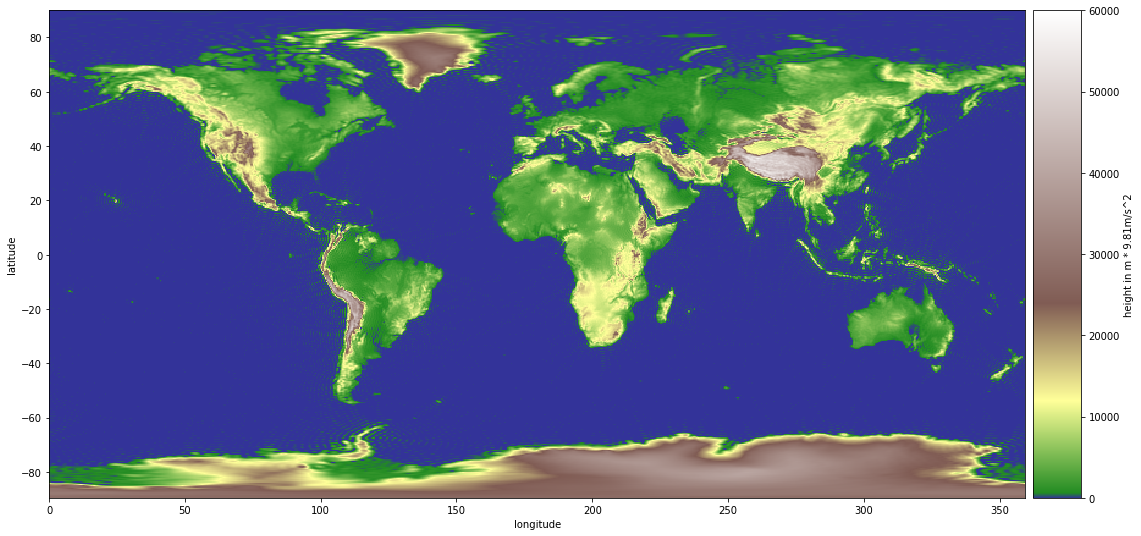

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
import spharm
import numpy as np
loaded = np.load('T1279_geo.npz')
rawData = loaded['spectraldata']
cm.register_cmap('topo', data=cdict)
nlats = 400; nlons = 2*nlats
N = 399; # output truncation
specData = truncateData(N,1279,rawData)
plotSpectralData(specData,nlons,nlats,topocm,0,60000,'height in m * 9.81m/s^2')

#### 1.1.4 truncating the spectral data
The idea behind the spectral transform method on the sphere is to write the fields (surface pressure, two components of the horizontal wind velocity, temperature) as a sum of spherical basis functions. These basis functions are the spherical harmonics $Y_n^m$. The index $m$ is the zonal wavenumber and goes from 0 to the maximum wave number $M$. The number in our fileName is this maximum wave number $M$. The other index $n$ is the so called total wave number and goes from $m$ to $M$. A real valued function $f(\phi,\lambda)$ of the latitude $\phi$ and longitude $\lambda$ can be therefore be written as:

$$f(\phi,\lambda)=\Re\left(\sum_{m=0}^M\sum_{n=m}^M f_{m,n}~Y_n^m(\phi,\lambda)\right)$$

The spherical harmonics can be written as a product of exponential and Legendre functions which results in the following formula:

$$f(\phi,\lambda)=\Re\left(\sum_{m=0}^M \text{e}^{\text{i}m\lambda}\sum_{n=m}^M f_{m,n}P_n^m(\phi)\right)=\sum_{m=0}^M\sum_{n=m}^M \left(\cos(m\lambda)~\Re\left(f_{m,n}\right)P_n^m(\phi)-\sin(m\lambda)~\Im\left(f_{m,n}\right)P_n^m(\phi)\right)$$

where $P_n^m$ are the associated Legendre functions (here written for a transformed domain), the symbol $\Re(x)$ denotes the real part of a complex variable $x$ and $\Im(x)$ is the imaginary part of $x$.

Our data file `T1279_geo.npz` contains the complex spectral data $f_{n,m}$ as a one dimensional vector in the following order (the symbol $\Re(x)$ denotes the real part of a complex variable $x$ and $\Im(x)$ is the imaginary part of $x$):

|index |value $f_{n,m}$|n|m|
|:---------------------------------------:|:-----|:-:|:-:|
|$0$|$\Re(f_{0,0})$|$0$|$0$|
|$1$|$\Im(f_{0,0})$|$0$|$0$|
|$2$|$\Re(f_{1,0})$|$1$|$0$|
|$3$|$\Im(f_{1,0})$|$1$|$0$|
|$4$|$\Re(f_{2,0})$|$2$|$0$|
|$5$|$\Im(f_{2,0})$|$2$|$0$|
|$6$|$\Re(f_{3,0})$|$3$|$0$|
|$7$|$\Im(f_{3,0})$|$3$|$0$|
|⋮|⋮|⋮|⋮|
|$2M$|$\Re(f_{M,0})$|$M$|$0$|
|$2M+1$|$\Im(f_{M,0})$|$M$|$0$|
|$2M+2$|$\Re(f_{1,1})$|$1$|$1$|
|$2M+3$|$\Im(f_{1,1})$|$1$|$1$|
|⋮|⋮|⋮|⋮|
|$\mbox{(M+1)(M+2)-2}$|$\Re(f_{M,M})$|$M$|$M$|
|$\mbox{(M+1)(M+2)-1}$|$\Im(f_{M,M})$|$M$|$M$|

The total number of entries per level and field in our grib file is $(M+1)(M+2)$.  

[Proof (for those who are interested): $$\sum_{k=1}^Mk=\frac{1}{2}M(M+1) \Rightarrow \sum_{m=0}^M\sum_{n=m}^M1=\sum_{m=0}^M(M-m+1)=\frac{1}{2}(M+1)(M+2)$$]

To give you an example of how to work with this order we create in the next cell a new vector `truncatedData` which contains the spectral data from the grib-file only for $n<N$ and $m<N$, where $N<M$ is some new maximum wave number.

**Task:** Run the next cell and make sure that you understand the for-loops. You will use these for-loops a lot in the remaining exercises!

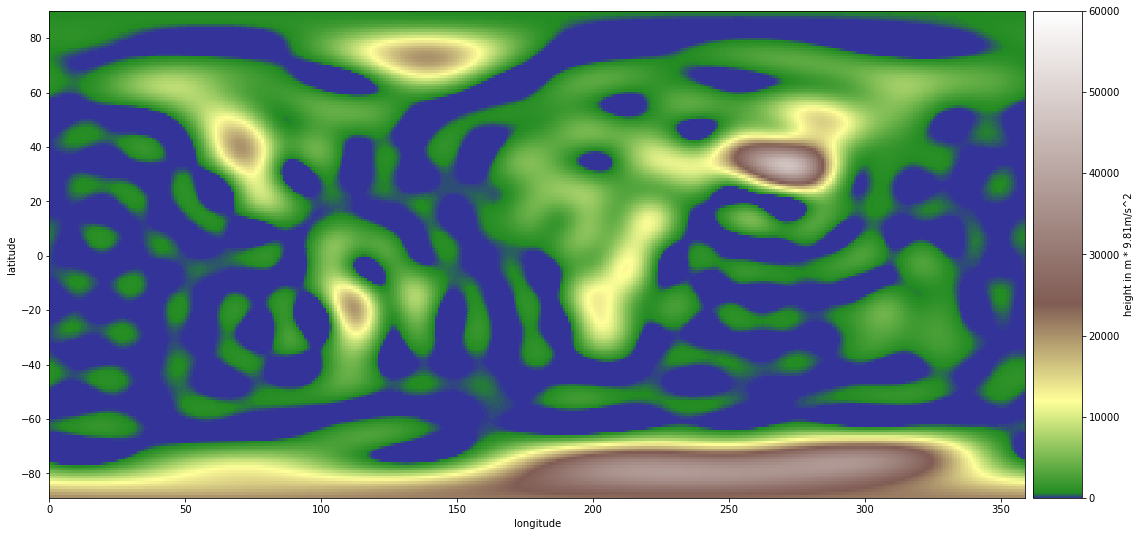

In [8]:
M = 159
N = 20
nlons = 360;  nlats = 181
loaded = np.load('T159_geo.npz')
rawData = loaded['spectraldata']
truncatedData = np.zeros((N+1)*(N+2))

k = 0; j=0
for m in range(0,M+1):
    for n in range(m,M+1):
        if n<=N and m<=N:
            truncatedData[j] = rawData[k]
            truncatedData[j+1] = rawData[k+1]
            j = j+2
        k = k+2

plotSpectralData(truncatedData,nlons,nlats,topocm,0,60000,'height in m * 9.81m/s^2')

#### 1.1.5 Interactive sliders
To make our experiments a little nicer we can add sliders to our plots with the following code. These allow us to quickly change the truncation $N$. The argument `continuous_update=False` in the slider for $N$ prevents Python from updating the plot while you are dragging the slider. This will be useful if the computation becomes slow.

**Task:** Run the cell and try the sliders. How does the result change when reducing $N$?

In [9]:
loaded = np.load('T159_geo.npz')
rawData = loaded['spectraldata']
def plotTruncated(N):
    truncatedData = np.zeros((N+1)*(N+2))
    k = 0; j=0
    for m in range(0,M+1):
        for n in range(m,M+1):
            if n<=N and m<=N:
                truncatedData[j] = rawData[k]
                truncatedData[j+1] = rawData[k+1]
                j = j+2
            k = k+2
    plotSpectralData(truncatedData,nlons,nlats,topocm,0,60000,'height in m * 9.81m/s^2')

N_widget = IntSlider(min=0,max=M,step=1,value=M/2, continuous_update=False)
interact(plotTruncated, N=N_widget)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT03OSwgY29udGludW91c191cGRhdGU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnTicsIG1heD0xNTkpLCBPdXRwdXQoKSksIF9kb23igKY=


<function __main__.plotTruncated>

### 1.2 Implement your own spectral transform algorithm
#### 1.2.1 Plot the spherical harmonics using spharm
Before you start implementing your own spherical harmonics you should first take a look at what the spharm library gives.

**Task:** Use the result of the following cell to check later if you computed your spherical harmonics correctly. The new functions `update_n_range` and `update_m_range` make sure that the sliders allow only the allowed wavenumbers where zonal wavenumber is smaller than the total wavenumber.

In [10]:
maxN = 180 # maximum wavenumber for the sliders
# plot resolution:
nlonsPlot=600
nlatsPlot=300

def plotSph(n,m):
    data = np.zeros((n+1)*(n+2))
    k = 0
    for mm in range(0,n+1):
        for nn in range(mm,n+1):
            if nn==n and mm==m:
                data[k+1] = 1.0 # k: real part, k+1: would be imaginary part
            k = k+2
    plotSpectralData(data,nlonsPlot,nlatsPlot,cm.RdBu_r,-4,4,'')

n_widget = IntSlider(min=0,max=min(maxN,nlatsPlot-1,(nlonsPlot-1)/2),step=1,value=maxN/4)
m_widget = IntSlider(min=0,max=min(maxN,nlatsPlot-1,(nlonsPlot-1)/2),step=1,value=maxN/8)
def update_n_range(*args):
    n_widget.min = m_widget.value
n_widget.observe(update_n_range, 'value')
def update_m_range(*args):
    m_widget.max = n_widget.value
m_widget.observe(update_m_range, 'value')
interact(plotSph, n=n_widget, m=m_widget)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT00NSwgZGVzY3JpcHRpb249dSduJywgbWF4PTE4MCksIEludFNsaWRlcih2YWx1ZT0yMiwgZGVzY3JpcHRpb249dSdtJywgbWHigKY=


<function __main__.plotSph>

#### 1.2.2 Compute the spherical harmonics from the Legendre functions
It is quite difficult to compute the Legendre functions accurately for high wave numbers. We will use Legendre functions from spharm. The following cell computes an array `legMaxN` which contains the values of $P_n^m$ for all wavenumbers up to wavenumber `maxN` and for all latitudes. The cell also computes an array `knmax` which gives us the index in `legMaxN` for each zonal wavenumber `m` and total wavenumber `n`. The value `legMaxN[knmax[m,n],ilat]` is the value of $P_n^m$ for zonal wavenumber `m`, total wavenumber `n` and at the latitude (in degrees) `lats[ilat]`.

In [9]:
from tqdm import tqdm
M = 159
maxN = 200
nlons = 300;  nlats = 300
loaded = np.load('T159_geo.npz')
rawData = loaded['spectraldata']

# mesh:
lons = np.arange(0.,360,360./nlons)
lats = np.arange(90.,-90.,-180./nlats)
lonsMesh, latsMesh = np.meshgrid(lons, lats)
phi = (lons)/180.*np.pi

# compute Legendre functions up to wave number maxN for all latitudes:
legMaxN = np.zeros([(maxN+1)*(maxN+2)//2,nlats])
for ilat in tqdm(range(0,nlats)):
    legMaxN[:,ilat] = spharm.legendre(lats[ilat],maxN)
legMaxN = legMaxN/legMaxN[0,0]
legMaxN[maxN+1:,:] *= 2.
# compute helper array knmax that gives index in legMaxN for a certain zonal and total wave number:
j = 0
knmax = np.zeros([maxN+1,maxN+1], np.int)
for m in range(0,maxN+1):
    for n in range(m,maxN+1):
        knmax[m,n] = j
        j += 1

100%|██████████| 300/300 [00:08<00:00, 37.60it/s]


**Taks:** Now it is your turn: use `legMaxN` to plot the spherical harmonics by completing the incomplete line in the following cell! Make sure that you get the same result like before! Test the real as well as imaginary part of the spherical harmonics!

In [ ]:
def plotSph(n,m):
    gpData = np.zeros([nlats,nlons])
    for ilon in range(0,nlons):
        for ilat in range(0,nlats):
            gpData[ilat,ilon] = # *** TASK: COMPLETE THIS LINE! ***
    plotGlobe(lons,lats,gpData,cm.RdBu_r,-4,4,'')

n_widget = IntSlider(min=0,max=maxN,step=1,value=maxN/4)
m_widget = IntSlider(min=0,max=maxN,step=1,value=maxN/8)
def update_n_range(*args):
    n_widget.min = m_widget.value
n_widget.observe(update_n_range, 'value')
def update_m_range(*args):
    m_widget.max = n_widget.value
m_widget.observe(update_m_range, 'value')
interact(plotSph, n=n_widget, m=m_widget)

#### 1.2.3 Perform the spectral transform with your own spherical harmonics
**Reminder:** The function $f$ in physical (grid point) space can be computed out of the spectral data $f_{m,n}$ with the following formula:
$$f(\phi,\lambda)=\sum_{m=0}^M \text{e}^{\text{i}m\lambda}\sum_{n=m}^M f_{m,n}P_n^m(\phi)$$
**Task:** Implement this formula with the help of the array `legMaxN` by completing the following cell. The spectral data is in the array `rawData` and you need to compute the data in grid point space `gpData`. You should go with for-loops through all wavenumbers, longitudes and latitudes. We will think about avoiding some of this work later. Your outermost loop should be over the zonal wave numbers. This will make our next steps easier. You can use `tqdm(range(...))` for the outermost loop. This will give you a nice progress bar and it will tell you how much time has past.

**Tip:** If your result is not the same like before: create a vector `rawData` that is one in one single entry and zero in all the other entries. Compare this with the corresponding spherical harmonics that you plotted before. The information for which wavenumbers the result is wrong might help you in finding the bug.

In [10]:
def plotSph(n,m):
    gpData = np.zeros([nlats,nlons])
    # *** TASK: COMPUTE GRID POINT DATA BY USING legMaxN ***
    plotGlobe(lons,lats,gpData,cm.RdBu_r,-4,4,'')

n_widget = IntSlider(min=0,max=maxN,step=1,value=maxN/4)
m_widget = IntSlider(min=0,max=maxN,step=1,value=maxN/8)
def update_n_range(*args):
    n_widget.min = m_widget.value
n_widget.observe(update_n_range, 'value')
def update_m_range(*args):
    m_widget.max = n_widget.value
m_widget.observe(update_m_range, 'value')
interact(plotSph, n=n_widget, m=m_widget)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT01MCwgZGVzY3JpcHRpb249dSduJywgbWF4PTIwMCksIEludFNsaWRlcih2YWx1ZT0yNSwgZGVzY3JpcHRpb249dSdtJywgbWHigKY=


<function __main__.plotSph>

Did you manage to get the same result like with the spharm library when using the same resolution? The next cell contains again the result with spharm (copied from above) for quicker comparison.

In [17]:
loaded = np.load('T159_geo.npz')
rawData = loaded['spectraldata']
def plotTruncated(N):
    truncatedData = np.zeros((N+1)*(N+2))
    k = 0; j=0
    for m in range(0,M+1):
        for n in range(m,M+1):
            if n<=N and m<=N:
                truncatedData[j] = rawData[k]
                truncatedData[j+1] = rawData[k+1]
                j = j+2
            k = k+2
    plotSpectralData(truncatedData,nlons,nlats,topocm,0,60000,'height in m * 9.81m/s^2')

N_widget = IntSlider(min=0,max=M,step=1,value=M/2, continuous_update=False)
interact(plotTruncated, N=N_widget)

interactive(children=(IntSlider(value=79, continuous_update=False, description='N', max=159), Output()), _dom_…

<function __main__.plotTruncated(N)>

### 1.3 Improving the performance
#### 1.3.1 Reduce number of operations
You probably noticed that going with a for-loop through all wavenumbers, all longitudes and all latitudes is very slow. We need to find a way to avoid some of these computations. The product between spectral data and Legendre functions (the so called Legendre transformation) does not depend on the latitude.

**Task:** Make a copy of your previous version and compute the product of spectral data and Legendre functions only once for every zonal wavenumber. How much faster does the code run compared to the previous version? (You can compare the runtime shown by tqdm to get a rough idea.)

In [1]:
# *** TASK: WRITE YOUR CODE HERE ***

#### 1.3.2 Using the Fast Fourier Transformation
The factor $\text{e}^{\text{i}m\lambda}$ in the spectral transform can be computed by using a Fast Fourier Transformation. This reduces the amount of work by computing the Fourier transformation recursively. IFS uses an FFT library called FFTW. We can use this library here by using the Python function `pyfftw.interfaces.numpy_fft.ifft`. If you apply this function on a vector with $M$ zonal wavenumbers and multiply the result with the number of values it will give you the same number of grid point values distributed uniformly around the globe. You need to remove the highest wavenumbers if your number of longitudes is smaller than $M$ or add zeros if you need more grid points.

**Task:** Make a copy of your last spectral transform and use FFT to speed up your computations.

In [2]:
# *** TASK: WRITE YOUR CODE HERE ***

#### 1.3.3 Parallelize the computation of the Legendre functions
All our computations so far used only one processor. Most computers (and even those on which Azure is running their Python notebooks) have multiple processors. We can take advantage of those processors by parallelizing our code. We start by parallelizing the computation of the Legendre functions.

We use a simple task based parallelization. This way we don't need to worry about giving all processors the exactly same amount of work. If one processor finishes one task it will simply continue with the next. If you have a loop like
```python
for x in tqdm(range(...)):
    result[:,ilat] = someFunction(x) # someFunction returns a 1D vector
```

you can parallelize this loop by replacing it with
```python
def parallelFunction(x):
    return someFunction(x)
num_cores = multiprocessing.cpu_count()
parallelOut = Parallel(n_jobs=num_cores)(delayed(parallelFunction)(x) for x in tqdm(range(...)))
result = np.dstack(parallelOut)
```

**Task:** Parallelize the computation of legMaxN. How many cores are you using? How much faster does it get compared to before?

In [22]:
from joblib import Parallel, delayed
import multiprocessing
M = 1279
maxN = 200
nlons = 360;  nlats = 181
loaded = np.load('T1279_geo.npz')
rawData = loaded['spectraldata']

# mesh:
lons = np.arange(0.,360,360./nlons)
lats = np.arange(90.,-90.,-180./nlats)
lonsMesh, latsMesh = np.meshgrid(lons, lats)
phi = (-lons)/180.*np.pi

# compute Legendre functions up to wave number maxN for all latitudes:
def legParallel(ilat):
    return spharm.legendre(lats[ilat],maxN)
num_cores = multiprocessing.cpu_count()
parallelOut = Parallel(n_jobs=num_cores)(delayed(legParallel)(ilat) for ilat in tqdm(range(0,nlats)))
legMaxN = np.dstack(parallelOut)
legMaxN = legMaxN[0]/legMaxN[0,0,0]
legMaxN[maxN+1:,:] *= 2.

# compute helper array knmax that gives index in legMaxN for a certain zonal and total wave number:
j = 0
knmax = np.zeros([maxN+1,maxN+1], np.int)
for m in range(0,maxN+1):
    for n in range(m,maxN+1):
        knmax[m,n] = j
        j += 1

100%|██████████| 181/181 [00:03<00:00, 47.64it/s]


In [3]:
# *** COPY HERE YOUR SPECTRAL TRANSFORM TO CHECK THE RESULT ***

#### 1.3.4 Parallelize the Legendre transform
The computation for the different zonal wavenumbers $m$ in the Legendre transformation is also independent of each other.

**Task:** Parallelize the Legendre transformation by using the same approach like for the Legendre functions. Use your new function to plot the result interactively with the sliders. The sliders become more fun to use the faster we make our code.  
**As a side task:** recompute the grid point data only when $N$ gets changed, not when `lat0` or `lon0` is changed. This makes the sliders for `lat0` and `lon0` even more responsive.

In [4]:
# *** TASK: WRITE YOUR CODE HERE ***

##### To think about:
All our variables in Python are stored in one shared memory. We don't need to worry about sending data between different nodes of our computer. This is of course different for the weather prediction at ECMWF. An important open scientific question is: how can we minimize the amount of data that needs to be sent between different processors in between Legendre and Fourier transformation? Do you see why this is a big challenge?
#### 1.3.5 Take advantage of the symmetry of the Legendre functions
To be able to use the full operational resolution of ECMWF with 1279 wavenumbers we need to speed up our Legendre functions a little more. We can make them two times faster by taking advantage of the symmetry of the Legendre functions:
$$P_n^m(-\phi)=(-1)^{m+n}P_n^m(\phi)$$
**Task:** Make a copy of your last version of computing the Legendre functions and compute half of the latitudes by using this symmetry relation. Check your result by using these Legendre functions in your spectral transform and comparing the plot with your previous results.

In [5]:
# *** TASK: WRITE YOUR CODE HERE ***

#### 1.3.6 Pre-compute the data for multiple N and plot with plot.ly
Our spectral transform has become pretty quick. The most time consuming part of animating the results with the sliders is now the plot itself. We can switch to a different Python package called plotly. The following function requires the data to be precomputed for all $N$ and stored in a list of numpy arrays.

In [31]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

def plotlyPlot(lonsMesh,latsMesh,dataAllN):
    lons = np.concatenate((lonsMesh,lonsMesh[:,[0]]+360),1)
    lats = np.concatenate((latsMesh,latsMesh[:,[0]]),1)
    maxN2 = len(dataAllN)-1
    stepSize = 1
    dataAllN2 = [np.concatenate((dataAllN[n]/9.81,dataAllN[n][:,[0]]/9.81),1) for n in range(0,maxN2+1,stepSize)]
    steps = []
    for i in range(len(dataAllN2)):
        step = dict(
            method = 'restyle',
            args = ['visible', [False] * len(data)],
        )
        step['args'][1][i] = True # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active = maxN2,
        currentvalue = {"prefix": "Truncation: "},
        pad = {"t": 50},
        steps = steps
    )]
    dataPlotly = go.Data([{
      "x": np.multiply(np.cos((lons)/180.*np.pi),np.sin((90.-lats)/180.*np.pi)),
      "y": np.multiply(np.sin((lons)/180.*np.pi),np.sin((90.-lats)/180.*np.pi)),
        "z": np.cos((90.-lats)/180.*np.pi)+0.5,
        "autocolorscale": False, 
      "cauto": False, 
      "cmax": 6000.0, 
      "cmin": 0.0, 
      "colorscale": [
        [0.0, "rgb(51,51,153)"], [0.01, "rgb(34,139,34)"], [0.2, "rgb(255,255,153)"], [0.4, "rgb(128,92,84)"], [1, "rgb(255,255,255)"]], 
      "lighting": {
        "ambient": 0.82, 
        "diffuse": 1.0, 
        "fresnel": 0, 
        "roughness": 0.22, 
        "specular": 0.14
      }, 
      "lightposition": {
        "x": 10, 
        "y": -10, 
        "z": 1
      }, 
      "reversescale": False, 
      "surfacecolor": dataAllN2[n],
      "type": "surface" 
    } for n in tqdm(range(len(dataAllN2)))])
    dataPlotly[len(dataAllN2)-1]['visible'] = True
    layout = {
      "autosize": False, 
      "height": 1000, 
      "margin": {
        "r": 50, 
        "t": 90, 
        "b": 65, 
        "l": 65
      }, 
      "scene": {
        "aspectratio": {
          "x": 0.999987447389, 
          "y": 0.999987447389, 
          "z": 1.0000251057
        }, 
        "camera": {
          "center": {
            "x": 0, 
            "y": 0, 
            "z": 0
          }, 
          "eye": {
            "x": 1.24176115571, 
            "y": 0.432879050248, 
            "z": 0.425496831744
          }, 
          "up": {
            "x": 0, 
            "y": 0, 
            "z": 1
          }
        }, 
        "xaxis": {
          "showgrid": False, 
          "showline": False, 
          "showticklabels": False, 
          "title": "<br>", 
          "zeroline": False
        }, 
        "yaxis": {
          "showgrid": False, 
          "showticklabels": False, 
          "title": "<br>", 
          "zeroline": False
        }, 
        "zaxis": {
          "showgrid": False, 
          "showticklabels": False, 
          "title": "<br>", 
          "zeroline": False
        }
      }, 
      "title": "Orography in meters", 
      "width": 1000,
        "sliders": sliders
    }

    fig = go.Figure(data=dataPlotly, layout=layout)
    iplot(fig)

If you run this notebook on Azure the RAM that Python gets is very limited. Plotly will probably only work for very low resolution of `nlats=100` and `nlons=100` and precomputing the following range of values of $N$:

In [33]:
nRange = [2**x for x in range(0,int(np.log2(maxN))+1)]
print(nRange)

[1, 2, 4, 8, 16, 32, 64, 128]


**Task:** Modify your spectral transform to precompute the grid point data for all of these values of $N$ and use the plotly function above to plot them. If you run this on your local computer you can use a slightly higher resolution and more values for $N$. For comparison: you can find a result obtained for `nlats=181`, `nlons=360` and `nRange = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]` under the following link: https://cdn.rawgit.com/anmrde/spectral/00da88e3/degreeMesh.html


In [6]:
# *** TASK: WRITE YOUR CODE HERE ***

### 1.4 Filter
There are some unrealistic looking green waves in the ocean for $N$ around 32. We can get rid of these waves by using a filter. We use here the following filter:
$$f_{m,n}^\text{filtered}=\left(\frac{(N-n)(N-n+1)}{N(N+1)}\right)^p f_{m,n}$$
The exponent $p$ needs to be chosen such that the result looks best. You should start with $p=1$.

**Task:** implement this filter in your spectral transform and plot the result with plotly. How does the behavior change compared to the unfiltered previous result?

In [7]:
# *** TASK: WRITE YOUR CODE HERE ***

##### To think about:
Filters like the one you just implemented have the negative side effect of reducing the amplitude of the field. In the case of the orography this means that we basically loose the Mount Everest. An important open scientific question is: how can we filter unwanted oscillations without loosing much amplitude?
### 1.5 The power spectrum
Computing the power spectrum is an important way to check the accuracy of the result. This is usually done for fields like the wind velocity because the square of wind velocity has the physical meaning of the kinetic energy. It can also be very useful to plot the spectrum even for quantities like the geopotential.
#### 1.5.1 Plot the power spectrum of the initial data
The following function computes the spectrum of the geopotential from our data file and plots it. You will use this function in your next task below.

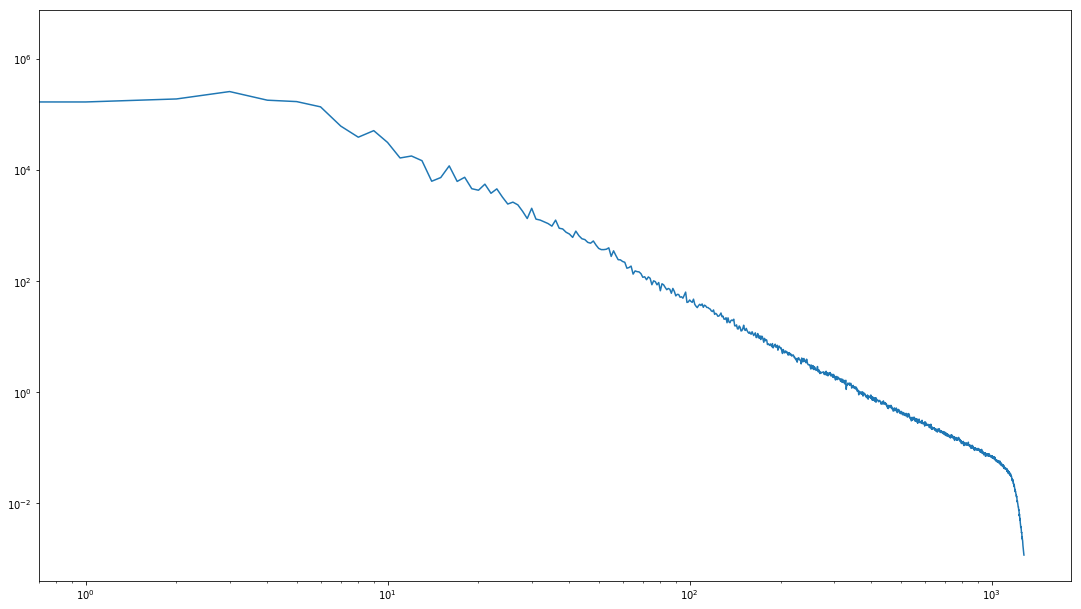

In [37]:
loaded = np.load('T1279_geo.npz')
rawData = loaded['spectraldata']
M = 1279

def spectrumFct(rawData,M):
    data = np.zeros(M+1)
    k = 0
    for m in range(0,M+1):
        zmet = 1.
        if m==0:
            zmet = 0.5 # normalization of Fourier modes (integral over square is 1 for m=0 but 1/2 for m>0)
        for n in range(m,M+1):
            data[n] += zmet*(rawData[k]**2+rawData[k+1]**2)/(2.*n+1)
            k = k+2
    return data

data = spectrumFct(rawData,M)
plt.loglog(range(0,M+1),data)
ax = plt.gca()
ax.relim()
ax.autoscale_view()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

#### 1.5.2 Implement the direct transformation and check the spectrum
Our goal is to compare the spectrum of the initial data with the spectrum of our grid point data. We need to transform our grid point data back to spectral space for this purpose. This so called direct spectral transform is given by the following formula:
$$f_m(\phi)=\text{FFT}(f(\cdot,\phi))$$

$$f_{m,n}=\frac{1}{2}\int_{-1}^1f_m(\phi)P_n^m[\cos(\theta)]d\cos(\theta),~~\text{with}~~\theta=90°-\phi$$
We approximate this integral with the trapezoidal rule by using the following formula:
$$f_{m,n}=\frac{1}{4}\sum_{\phi=-90°}^{90°-\Delta\phi}\left(f_m(\phi)P_n^m(\phi)+f_m(\phi+\Delta\phi)P_n^m(\phi+\Delta\phi)\right)$$
For simplicity we assume that the number of longitudes is equal to $M$ for this subsection.

**Task:** Add the direct spectral transform to your previous version of the spectral transform by implementing these formulas and plot the resulting spectrum together with the initial spectrum in one plot. Use `T159_geo.npz`, `M=159` and `nlats=181`.

In [ ]:
# *** TASK: WRITE YOUR CODE HERE ***

#### 1.5.3 Aliasing
If you have less latitudes than wavenumbers and still continue to use all wave numbers in your computation you get so called aliasing. This happens in the weather forecast due to non-linear terms if the resolution of the grid is not fine enough. This can be demonstrated very well in the spectrum.

**Task:** Make a copy of your last code and reduce the number of latitudes to `nlats=60`. How did the spectrum change? Show that you can remove aliasing by removing the highest wavenumbers in your spectral data.

In [ ]:
# *** TASK: WRITE YOUR CODE HERE ***

#### 1.5.4 Spectral filter in the spectrum
**Task:** Apply the filter from section 1.4 to the result of your direct spectral transform. Does it bring the spectrum closer to the initial spectrum?

In [ ]:
# *** TASK: WRITE YOUR CODE HERE ***

## References

More information about the spectral transform method and about computational challenges on different computing architectures can be found in the following recent paper: https://doi.org/10.5194/gmd-2018-304


## Acknowledgements

These exercises were first created for the ESCAPE summer school 2017 in Copenhagen, Denmark. The ESCAPE-1 and ESCAPE-2 projects have received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement No 671627 (ESCAPE) and No 800897 (ESCAPE2). More information about ESCAPE can be found at http://www.hpc-escape.eu